In [1]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.stats import skew, kurtosis
import itertools
import pickle
import glob
import seaborn as sns
import time
from copy import deepcopy
from sklearn.metrics import accuracy_score

import wfdb
from biosppy.signals import ecg
import nolds
import sampen

import sleep_utils as su

%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

### Load Classifiers and Scaler

In [2]:
classifier_without_prevstage = pickle.load(open("sleep_stage_classifier_without_previousstage_update.pkl", "rb" ))
classifier_with_prevstage = pickle.load(open("sleep_stage_classifier_with_previousstage_update.pkl", "rb" ))

Scaling_Function_physio = pickle.load(open("scaling_function_without_previousstage_update.pkl", "rb" ))
Scaling_Function_all = pickle.load(open("scaling_function_with_previousstage_update.pkl", "rb" ))

### Load data

In [3]:
data_dir = '../data/PSG_database/'

sleep_data_sigs = {}
sleep_data_fields = {}

data_keys = []
for fname in glob.iglob(data_dir + '/*.dat'):#, recursive=True):
    # filename manipulation
    base = os.path.basename(fname)
    key = os.path.splitext(base)[0]
    data_keys.append(key)
    
    # load data
    sig, fields=wfdb.rdsamp(data_dir+key)
    sleep_data_sigs[key] = sig
    sleep_data_fields[key] = fields

In [4]:
# load labels 
ann_index = {}
ann_labels = {}

set_stages = set()
for key in data_keys:
    annotation = wfdb.rdann(data_dir + key, 'st')
    ann_index_sig = annotation[0]
    ann_label_sig = annotation[5]
    label_filt = [(x, y) for x, y in zip(ann_index_sig, ann_label_sig) if x >1 ]
    unzipped = zip(*label_filt)
    ann_index[key] = unzipped[0]
    ann_labels[key] = unzipped[1]

In [5]:
resp_data_set = {}
ecg_data_set = {}
time_data_set = {}
annot_data_set = {}

fs = 250

for key in data_keys:
    
    resp_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('Resp')]
    ecg_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('ECG')]
    time_data_set[key] = np.arange(0, len(resp_data_set[key]))/fs

    # Note: Only the first character of the annotation was taken as label
    # Example: 1, 2, 3, 4, R, W, M
    stages_list = [x.rsplit(' ')[0][0] for x in ann_labels[key]]

    annot_data_set[key] = stages_list


In [6]:
# keys corresponding to patients in the database
data_keys

['slp01a',
 'slp01b',
 'slp02a',
 'slp02b',
 'slp03',
 'slp04',
 'slp14',
 'slp16',
 'slp32',
 'slp37',
 'slp41',
 'slp45',
 'slp48',
 'slp59',
 'slp60',
 'slp61',
 'slp66',
 'slp67x']

In [7]:
key_patient = data_keys[0]
print(key_patient)

slp01a


#### *Divide sample into epochs*

In [8]:
win_dur = 30 # duration of window, unit: seconds, size of one epoch 

In [9]:
# Respiratory frequency range 
min_normrange = 4/60 # unit: cycles per second
max_normrange = 65/60 # unit: cycles per second

resp_data_set_epochs = {}

resp_sig = resp_data_set[key_patient]
fft_resp = np.fft.fft(resp_sig)
fft_freqs = np.fft.fftfreq(len(resp_sig), 1/fs)

# Remove frequencies which are outside the expected range
fft_resp[abs(fft_freqs) < min_normrange] = 0
fft_resp[abs(fft_freqs) > max_normrange] = 0

resp_filt_sig = np.real(np.fft.ifft(fft_resp))
time_sig = np.arange(len(resp_sig))/fs

resp_windows = su.divide_to_epochs(resp_filt_sig, ann_index[key_patient], win_dur, fs)
time_windows = su.divide_to_epochs(time_sig, ann_index[key_patient], win_dur, fs)
resp_data_set_epochs[key_patient] = pd.DataFrame({'resp': list(resp_windows), '_time': list(time_windows)})


In [10]:
ecg_data_set_epochs = {}

ecg_sig = ecg_data_set[key_patient]
time_sig = np.arange(len(ecg_sig))/fs

ecg_windows = su.divide_to_epochs(ecg_sig, ann_index[key_patient], win_dur, fs)
time_windows = su.divide_to_epochs(time_sig, ann_index[key_patient], win_dur, fs)
ecg_data_set_epochs[key_patient] = pd.DataFrame({'ecg': list(ecg_windows), '_time': list(time_windows)})

## Extract features

In [11]:
resp_data = resp_data_set_epochs[key_patient]
ecg_data = ecg_data_set_epochs[key_patient]
annot_data = annot_data_set[key_patient]

In [12]:
label_dict = dict(zip(['1', '2', '3', '4', 'R', 'W', 'M'], [1, 2, 3, 3, 4, 5, 6]))
label = [label_dict[x] for x in annot_data]

In [13]:
def compute_features(resp_data, ecg_data, annot_data = None, with_previous_stage = True):
    features = []
    if with_previous_stage:
        
        # Minimum vs mean of respiration signal amplitude
        amplitude = resp_data.resp.apply(lambda x: su.compute_amplitude(x, fs, 'resp'))
        features.append(amplitude.apply(lambda x: np.nanmin(x)/np.nanmean(x)).values)
        
        # Maximum magnitude of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: np.nanmax(x)).values)
    
        # Standard deviation of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: np.nanstd(x)).values)
        
        # Standard deviation vs mean of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: np.nanstd(x)/np.nanmean(x)).values)
        
        # Zero crossings count of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: su.Zero_Crossing_Counts(x)).values)
                
        # Kurtosis of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: kurtosis(x)).values)     

        # Skewness of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: skew(x)).values)     
    
        previous = annot_data[1:]
        prev_stage = [np.nan] + previous
        
        # NREM-light or not
        features.append([np.nan] + map(lambda x: 0 if x not in ['1', '2'] else 1, previous))
    
        # NREM-deep or not
        features.append([np.nan] +map(lambda x: 0 if x not in ['3', '4'] else 1, previous))
    
        # REM or not
        features.append([np.nan] + map(lambda x: 0 if x!= 'R' else 1, previous))
    
        # Wake or not
        features.append([np.nan] + map(lambda x: 0 if x!= 'W' else 1, previous))
        
        # Movement or not
        features.append([np.nan] + map(lambda x: 0 if x!= 'M' else 1, previous))
    
    else:
        
        # Respiration rate
        resp_data['power_spectrum'] = resp_data.resp.apply(lambda x: ss.periodogram(x, fs=fs))
        features.append(resp_data.power_spectrum.apply(lambda x: (x[0])[np.argmax(x[1])]*60).values)

        # Maximum magnitude of respiration signal
        features.append(resp_data.resp.apply(lambda x: np.nanmax(x)).values)
   
        # Standard deviation of respiration signal
        features.append(resp_data.resp.apply(lambda x: np.nanstd(x)).values)
    
        #  Zero crossings count of respiration signal
        features.append(resp_data.resp.apply(lambda x: su.Zero_Crossing_Counts(x)).values)
        
        # Get time corresponding to R peaks
        ecg_data['r_peaks'] = ecg_data.ecg.apply(lambda x: ecg.hamilton_segmenter(x, sampling_rate=250)['rpeaks'])
        ecg_data['r_time'] = ecg_data.apply(lambda x: list(x._time[x.r_peaks]), axis = 1)
    
        # Heart rate variability
        features.append(ecg_data.r_time.apply(lambda x: su.heart_rate_var(np.array(x))*1000).values)
    
        # Mean magnitude of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: np.nanmean(x)).values)
        
        # Maximum magnitude of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: np.nanmax(x)).values)
            
        # Standard deviation of magnitude of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: np.std(x)).values)
    
        # Standard deviation vs mean of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: np.nanstd(x)/np.nanmean(x)).values)

        # Mean vs standard deviation of ECG signal amplitude
        amplitude = ecg_data.ecg.apply(lambda x: su.compute_amplitude(x, fs, 'ecg'))
        features.append(amplitude.apply(lambda x: np.nanmean(x)/np.nanstd(x)).values)
    
        # Sample entropy of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: (nolds.sampen(x))).values)   
    
        # Zero crossings count of ECG signal
        features.append(ecg_data.ecg.apply(lambda x: su.Zero_Crossing_Counts(x)).values)   
    
        # Kurtosis of ecg
        features.append(ecg_data.ecg.apply(lambda x: kurtosis(x)).values) 
    
        # Skewness of ecg
        features.append(ecg_data.ecg.apply(lambda x: skew(x)).values)
    
    return features

#### *Calculate features without previous stage*

In [14]:
feat_set1 = compute_features(resp_data, ecg_data, with_previous_stage = False)

Standardize the computed features features using the scaling function (column 1: mean, column 2: std)

In [15]:
features1 = ((np.vstack(feat_set1)).T - Scaling_Function_physio[:, 0])/Scaling_Function_physio[:, 1]
features1 = features1[np.isfinite(features1).all(axis=1)]

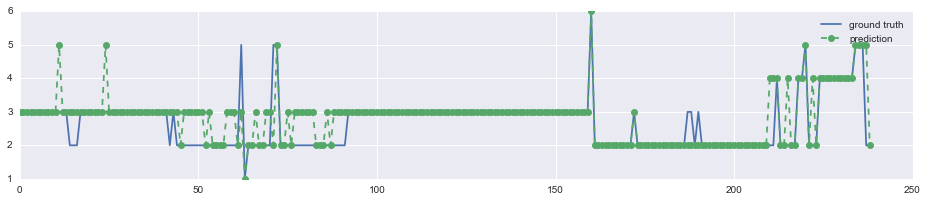

In [16]:
plt.figure(figsize=[16, 3])
plt.plot(label, label = 'ground truth')
plt.plot(classifier_without_prevstage.predict(features1), '--o', label = 'prediction')
plt.legend(loc= 1)

In [17]:
print("Accuracy: {}".format(accuracy_score(label, classifier_without_prevstage.predict(features1))))

Accuracy: 0.824267782427


#### *Calculate features with previous stage*

In [18]:
feat_set2 = compute_features(resp_data, ecg_data, annot_data, with_previous_stage = True)

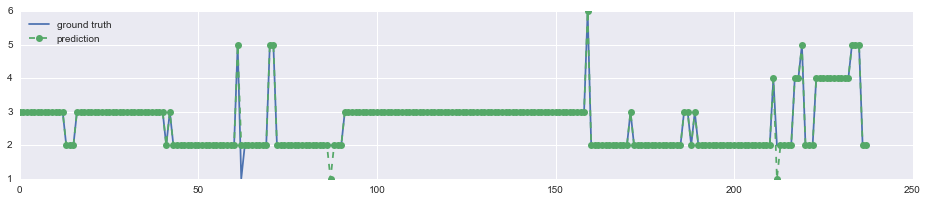

In [19]:
features2 = ((np.vstack(feat_set2)).T - Scaling_Function_all[:, 0])/Scaling_Function_all[:, 1]
features2 = features2[np.isfinite(features2).all(axis=1)]

plt.figure(figsize=[16, 3])
plt.plot(label[1:], label = 'ground truth')
plt.plot(classifier_with_prevstage.predict(features2), '--o', label = 'prediction')
plt.legend(loc= 'best')

In [20]:
print("Accuracy: {}".format(accuracy_score(label[1:], classifier_with_prevstage.predict(features2))))

Accuracy: 0.987394957983


## Sequential prediction

In [21]:
def compute_features_per_epoch(resp_data, ecg_data, annot_data = None, with_previous_stage = True):
    features = []
    if with_previous_stage:
        # Minimum vs mean of respiration signal amplitude
        amplituderesp = su.compute_amplitude(resp_data, fs, 'resp')
        features.append(np.nanmin(amplituderesp)/np.nanmean(amplituderesp))
        
        # Maximum magnitude of ECG signal
        features.append(np.nanmax(ecg_data))
    
        # Standard deviation of ECG signal
        features.append(np.nanstd(ecg_data))
        
        # Standard deviation vs mean of ECG signal
        features.append(np.nanstd(ecg_data)/np.nanmean(ecg_data))
        
        # Zero crossings count of ECG signal
        features.append(su.Zero_Crossing_Counts(ecg_data))
                
        # Kurtosis of ECG signal
        features.append(kurtosis(ecg_data))

        # Skewness of ECG signal
        features.append(skew(ecg_data))
        
        # NREM-light or not
        features.append(float(annot_data in [1, 2]))
    
        # NREM-deep or not
        features.append(float(annot_data == 3))
    
        # REM or not
        features.append(float(annot_data == 4))
    
        # Wake or not
        features.append(float(annot_data == 5))
        
        # Movement or not
        features.append(float(annot_data == 6))
        
    else:
        
        # Respiration rate
        power_spectrum = ss.periodogram(resp_data, fs=fs)
        features.append((power_spectrum[0])[np.argmax(power_spectrum[1])]*60)

        # Maximum magnitude of respiration signal
        features.append(np.nanmax(resp_data))
        
        # Standard deviation of respiration signal
        features.append(np.nanstd(resp_data))
    
        #  Zero crossings count of respiration signal
        features.append(su.Zero_Crossing_Counts(resp_data))
        
        # Get time corresponding to R peaks
        rpeaks = ecg.hamilton_segmenter(ecg_data, sampling_rate=250)['rpeaks']
        rtime = np.arange(0, 1/fs*len(ecg_data), 1/fs)[rpeaks]
    
        # Heart rate variability
        features.append(su.heart_rate_var(np.array(rtime))*1000)
    
        # Mean magnitude of ECG signal
        features.append(np.nanmean(ecg_data))
        
        # Maximum magnitude of ECG signal
        features.append(np.nanmax(ecg_data))
            
        # Standard deviation of magnitude of ECG signal
        features.append(np.std(ecg_data))
    
        # Standard deviation vs mean of ECG signal
        features.append(np.nanstd(ecg_data)/np.nanmean(ecg_data))

        # Mean vs standard deviation of ECG signal amplitude
        amplitudeecg = su.compute_amplitude(ecg_data, fs, 'ecg')
        features.append(np.nanmean(amplitudeecg)/np.nanstd(amplitudeecg))
        
        # Sample entropy of ECG signal
        features.append(nolds.sampen(ecg_data))
    
        # Zero crossings count of ECG signal
        features.append(su.Zero_Crossing_Counts(ecg_data))
    
        # Kurtosis of ECG signal
        features.append(kurtosis(ecg_data))
    
        # Skewness of ECG signal
        features.append(skew(ecg_data))
        
    
    return features

** *Note: The first epoch is predicted using the classifier trained on features excluding previous stage. The succeeding epochs are tested on the other classifier (with previous stage as features) but using the prediction of the previous epoch as input.* **

In [22]:
prediction = []

for i in range(len(resp_data)):
    resp_sig = resp_data.resp.ix[i]
    ecg_sig = ecg_data.ecg.ix[i]
    
    if i == 0:
        feats = compute_features_per_epoch(resp_sig, ecg_sig, with_previous_stage=False)
        feats = (feats - Scaling_Function_physio[:, 0])/Scaling_Function_physio[:, 1]
        prediction.append(classifier_without_prevstage.predict(feats.reshape(1, -1))[0])
                 
    else:
        feats = compute_features_per_epoch(resp_sig, ecg_sig, annot_data= prediction[-1], with_previous_stage=True)
        feats = (feats - Scaling_Function_all[:, 0])/Scaling_Function_all[:, 1]
        prediction.append(classifier_with_prevstage.predict(feats.reshape(1, -1))[0])
        
        

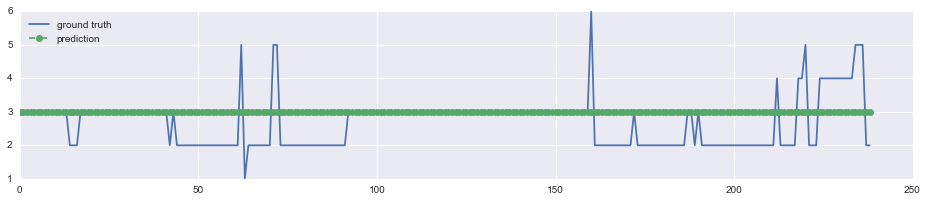

In [23]:
plt.figure(figsize=[16, 3])
plt.plot(label, label = 'ground truth')
plt.plot(prediction, '--o', label = 'prediction')
plt.legend(loc= 'best')

In [24]:
print("Accuracy: {}".format(accuracy_score(label, prediction)))

Accuracy: 0.468619246862


**Observation: **
    
The classifier trained on the the data set with previous stage as features assumes that the label of the previous stage is correct. Accuracy decreased drastically upon sequential prediction. 